## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera



## Introduction: Business Problem <a name="introduction"></a>

The aim of this project is to create an analysis of features for new restaurant to search a best neighborhood in Toronto as a comparative analysis between neighborhoods. Specifically, this report will be targeted to stakeholders interested in opening any business place. The first task would be to choose the safest borough by analyzing crime data for opening a new restaurant and short listing a neighborhood, and yet as close to the city as possible. We will make use of our data science tools to analyze data and focus on the safest borough and explore its neighborhoods and the 10 most common venues in each neighborhood so that the best neighborhood where restaurant store is not amongst the most common venue can be selected.

## Data <a name="data"></a>

Based on definition of our problem, factors that will influence our decission are:
* finding the safest borough based on crime statistics
* finding the most common venues
* choosing the right neighbourhood within the borough


###**Part 1:** Using a real world data set from Kaggle containing the Vancouver Crimes from 2003 to 2019<a name="part1"></a>


####  Vancouver Crime Report 

Properties of the Crime Report

*   TYPE - Crime type
*   YEAR - Recorded year
*   MONTH - Recorded month
*   DAY - Recorded day
*   HOUR - Recorded hour
*   MINUTE - Recorded minute
*   HUNDRED_BLOCK - Recorded block
*   NEIGHBOURHOOD - Recorded neighborhood
*   X - GPS longtitude
*   Y - GPS latitude

Data set URL: https://www.kaggle.com/agilesifaka/vancouver-crime-report/version/2

### Importing all the necessary Libraries

In [1]:

import numpy as np
import pandas as pd

#Command to install OpenCage Geocoder for fetching Lat and Lng of Neighborhood
!pip install opencage

#Importing OpenCage Geocoder
from opencage.geocoder import OpenCageGeocode

# use the inline backend to generate the plots within the browser
%matplotlib inline 

#Importing Matplot lib and associated packages to perform Data Visualisation and Exploratory Data Analysis
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot') # optional: for ggplot-like style

# check for latest version of Matplotlib
print ('Matplotlib version: ', mpl.__version__) # >= 2.0.0

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

#Importing folium to visualise Maps and plot based on Lat and Lng
import folium

#Requests to request web pages by making get requests to FourSquare REST Client
import requests

#To normalise data returned by FourSquare API
from pandas.io.json import json_normalize

#Importing KMeans from SciKit library to Classify neighborhoods into clusters
from sklearn.cluster import KMeans

print('Libraries imported')

Matplotlib version:  3.1.1
Libraries imported


In [2]:
vnc_crime_df = pd.read_csv('https://raw.githubusercontent.com/RamanujaSVL/Coursera_Capstone/master/vancouver_crime_records_2018.csv', index_col=None)

#Dropping X,Y which represents Lat, Lng data as Coordinates, the data seems to be corrupt
vnc_crime_df.drop(['Unnamed: 0','MINUTE', 'HUNDRED_BLOCK', 'X', 'Y'], axis = 1, inplace = True)

#vnc_crime_df.columns

vnc_crime_df.head()

,TYPE,YEAR,MONTH,DAY,HOUR,NEIGHBOURHOOD
0,Break and Enter Commercial,2018,3,2,6,West End
1,Break and Enter Commercial,2018,6,16,18,West End
2,Break and Enter Commercial,2018,12,12,0,West End
3,Break and Enter Commercial,2018,4,9,6,Central Business District
4,Break and Enter Commercial,2018,10,2,18,Central Business District


#### Changing the name of columns to lowercase

In [3]:
vnc_crime_df.columns = ['Type', 'Year','Month','Day','Hour','Neighbourhood']
vnc_crime_df.head()

,Type,Year,Month,Day,Hour,Neighbourhood
0,Break and Enter Commercial,2018,3,2,6,West End
1,Break and Enter Commercial,2018,6,16,18,West End
2,Break and Enter Commercial,2018,12,12,0,West End
3,Break and Enter Commercial,2018,4,9,6,Central Business District
4,Break and Enter Commercial,2018,10,2,18,Central Business District


###Total Crimes in different Neighborhoods

In [4]:
vnc_crime_df['Neighbourhood'].value_counts()

Central Business District    10857
West End                      3031
Mount Pleasant                2396
Strathcona                    1987
Kitsilano                     1802
Fairview                      1795
Renfrew-Collingwood           1762
Grandview-Woodland            1761
Kensington-Cedar Cottage      1391
Hastings-Sunrise              1270
Sunset                         967
Riley Park                     866
Marpole                        828
Victoria-Fraserview            600
Killarney                      565
Oakridge                       499
Dunbar-Southlands              474
Kerrisdale                     417
Shaughnessy                    414
West Point Grey                372
Arbutus Ridge                  311
South Cambie                   292
Stanley Park                   154
Musqueam                        17
Name: Neighbourhood, dtype: int64

**Part 2:** Gathering additional information about the Neighborhood from Wikipedia<a name="part2"></a>

As part of data set Borough which the neighborhood was part of was not categorized, so we will create a dictionary of Neighborhood and based on data in the following [Wikipedia page](https://en.wikipedia.org/wiki/List_of_neighbourhoods_in_Vancouver).

In [5]:
# define the dataframe columns
column_names = ['Neighbourhood', 'Borough'] 

# instantiate the dataframe
vnc_neigh_bor = pd.DataFrame(columns=column_names)

vnc_neigh_bor['Neighbourhood'] = vnc_crime_df['Neighbourhood'].unique()

neigh_bor_dict = {'Central Business District':'Central', 'West End':'Central', 'Stanley Park':'Central', 'Victoria-Fraserview':'South Vancouver',
                  'Killarney':'South Vancouver', 'Musqueam':'South Vancouver', 'Mount Pleasant':'East Side', 'Strathcona':'East Side',
                  'Renfrew-Collingwood':'East Side', 'Grandview-Woodland':'East Side', 'Kensington-Cedar Cottage':'East Side', 'Hastings-Sunrise':'East Side',
                  'Sunset':'East Side', 'Riley Park':'East Side', 'Kitsilano':'West Side', 'Fairview':'West Side',
                  'Marpole':'West Side', 'Oakridge':'West Side', 'Dunbar-Southlands':'West Side', 'Kerrisdale':'West Side',
                  'Shaughnessy':'West Side', 'West Point Grey':'West Side', 'Arbutus Ridge':'West Side', 'South Cambie':'West Side'}

for row, neigh in zip(neigh_bor_dict, vnc_neigh_bor['Neighbourhood']):
  vnc_neigh_bor.loc[vnc_neigh_bor.Neighbourhood == row, 'Borough'] = neigh_bor_dict.get(row)

vnc_neigh_bor.dropna(inplace=True)

print("Total Neighbourhood Count",len(vnc_neigh_bor['Neighbourhood']),"Borough Count",len(vnc_neigh_bor['Borough'].unique()))

vnc_neigh_bor.head()

Total Neighbourhood Count 24 Borough Count 4


,Neighbourhood,Borough
0,West End,Central
1,Central Business District,Central
2,Hastings-Sunrise,East Side
3,Grandview-Woodland,East Side
4,Mount Pleasant,East Side


###Merging the Crime data Table to include Boroughs

In [6]:
vnc_boroughs_crime = pd.merge(vnc_crime_df,vnc_neigh_bor, on='Neighbourhood')

vnc_boroughs_crime.head()

,Type,Year,Month,Day,Hour,Neighbourhood,Borough
0,Break and Enter Commercial,2018,3,2,6,West End,Central
1,Break and Enter Commercial,2018,6,16,18,West End,Central
2,Break and Enter Commercial,2018,12,12,0,West End,Central
3,Break and Enter Commercial,2018,3,2,3,West End,Central
4,Break and Enter Commercial,2018,3,17,11,West End,Central


Further Cleaning the data by dropping rows with invalid data

In [7]:
vnc_boroughs_crime.dropna(inplace=True)
vnc_boroughs_crime['Borough'].value_counts()

Central            14042
East Side          12400
West Side           7204
South Vancouver     1182
Name: Borough, dtype: int64

Methodology<a name="methodology"></a>

Categorized the methodologysection into two parts:

- [**Exploratory Data Analysis**:](#eda) Visualise the crime repots in different Vancouver boroughs to idenity the safest borough and normalise the neighborhoods of that borough. We will Use the resulting data and find 10 most common venues in each neighborhood.


- [**Modelling**:](#mdl) To help stakeholders choose the right neighborhood within a borough we will be clustering similar neighborhoods using K - means clustering which is a form of unsupervised machine learning algorithm that clusters data based on predefined cluster size. We will use K-Means clustering to address this problem so as to group data based on existing venues which will help in the decision making process.

Exploratory Data Analysis<a name="eda"></a>

Pivoting the table to better understand the data by crimes per borough

In [8]:
vnc_crime_cat = pd.pivot_table(vnc_boroughs_crime,
                               values=['Year'],
                               index=['Borough'],
                               columns=['Type'],
                               aggfunc=len,
                               fill_value=0,
                               margins=True)
vnc_crime_cat

Year                                    \
Type            Break and Enter Commercial Break and Enter Residential/Other   
Borough                                                                        
Central                                787                               198   
East Side                              786                              1043   
South Vancouver                         49                               156   
West Side                              403                              1000   
All                                   2025                              2397   

                                                                          \
Type            Mischief Other Theft Theft from Vehicle Theft of Bicycle   
Borough                                                                    
Central             2280        2489               6871              857   
East Side           2192        1674               4754              678   
South Vancouver      187          88                483               36   
West Side           1062         696               2838              588   
All                 5721        4947              14946             2159   

                                  \
Type            Theft of Vehicle   
Borough                            
Central                      245   
East Side                    605   
South Vancouver               71   
West Side                    225   
All                         1146   

                                                                        \
Type            Vehicle Collision or Pedestrian Struck (with Fatality)   
Borough                                                                  
Central                                                          1       
East Side                                                        8       
South Vancouver                                                  1       
West Side                                                        3       
All                                                             13       

                                                                             
Type            Vehicle Collision or Pedestrian Struck (with Injury)    All  
Borough                                                                      
Central                                                        314    14042  
East Side                                                      660    12400  
South Vancouver                                                111     1182  
West Side                                                      389     7204  
All                                                           1474    34828

Merging the Pivoted Column with other columns

In [9]:
vnc_crime_cat.reset_index(inplace = True)
vnc_crime_cat.columns = vnc_crime_cat.columns.map(''.join)
vnc_crime_cat.rename(columns={'YearAll':'Total'}, inplace=True)
# To ignore bottom All in Borough
vnc_crime_cat = vnc_crime_cat.head(4)
vnc_crime_cat

,Borough,YearBreak and Enter Commercial,YearBreak and Enter Residential/Other,YearMischief,YearOther Theft,YearTheft from Vehicle,YearTheft of Bicycle,YearTheft of Vehicle,YearVehicle Collision or Pedestrian Struck (with Fatality),YearVehicle Collision or Pedestrian Struck (with Injury),Total
0,Central,787,198,2280,2489,6871,857,245,1,314,14042
1,East Side,786,1043,2192,1674,4754,678,605,8,660,12400
2,South Vancouver,49,156,187,88,483,36,71,1,111,1182
3,West Side,403,1000,1062,696,2838,588,225,3,389,7204


Pivoting the table to better understand the data by crimes per neighborhood

In [10]:
vnc_crime_neigh = pd.pivot_table(vnc_boroughs_crime,
                               values=['Year'],
                               index=['Neighbourhood'],
                               columns=['Type'],
                               aggfunc=len,
                               fill_value=0,
                               margins=True)
vnc_crime_neigh

Year  \
Type                      Break and Enter Commercial   
Neighbourhood                                          
Arbutus Ridge                                     12   
Central Business District                        551   
Dunbar-Southlands                                  8   
Fairview                                         138   
Grandview-Woodland                               148   
Hastings-Sunrise                                  48   
Kensington-Cedar Cottage                          62   
Kerrisdale                                        24   
Killarney                                         34   
Kitsilano                                        106   
Marpole                                           44   
Mount Pleasant                                   205   
Musqueam                                           0   
Oakridge                                          19   
Renfrew-Collingwood                               91   
Riley Park                                        35   
Shaughnessy                                       12   
South Cambie                                      22   
Stanley Park                                       6   
Strathcona                                       160   
Sunset                                            37   
Victoria-Fraserview                               15   
West End                                         230   
West Point Grey                                   18   
All                                             2025   

                                                                      \
Type                      Break and Enter Residential/Other Mischief   
Neighbourhood                                                          
Arbutus Ridge                                            78       49   
Central Business District                               124     1812   
Dunbar-Southlands                                       106       81   
Fairview                                                 73      233   
Grandview-Woodland                                      162      304   
Hastings-Sunrise                                        117      195   
Kensington-Cedar Cottage                                145      255   
Kerrisdale                                               97       49   
Killarney                                                72       90   
Kitsilano                                               165      320   
Marpole                                                 125      134   
Mount Pleasant                                          124      353   
Musqueam                                                  4        3   
Oakridge                                                123       64   
Renfrew-Collingwood                                     156      243   
Riley Park                                              122      140   
Shaughnessy                                             120       41   
South Cambie                                             42       41   
Stanley Park                                              2        8   
Strathcona                                              124      527   
Sunset                                                   93      175   
Victoria-Fraserview                                      80       94   
West End                                                 72      460   
West Point Grey                                          71       50   
All                                                    2397     5721   

                                                                           \
Type                      Other Theft Theft from Vehicle Theft of Bicycle   
Neighbourhood                                                               
Arbutus Ridge                      18                111               12   
Central Business District        2034               5301              640   
Dunbar-Southlands                  31                199               16   


Merging the Pivoted Column with other columns

In [11]:
vnc_crime_neigh.reset_index(inplace = True)
vnc_crime_neigh.columns = vnc_crime_neigh.columns.map(''.join)
vnc_crime_neigh.rename(columns={'YearAll':'Total'}, inplace=True)

vnc_crime_neigh.head()

,Neighbourhood,YearBreak and Enter Commercial,YearBreak and Enter Residential/Other,YearMischief,YearOther Theft,YearTheft from Vehicle,YearTheft of Bicycle,YearTheft of Vehicle,YearVehicle Collision or Pedestrian Struck (with Fatality),YearVehicle Collision or Pedestrian Struck (with Injury),Total
0,Arbutus Ridge,12,78,49,18,111,12,12,1,18,311
1,Central Business District,551,124,1812,2034,5301,640,165,0,230,10857
2,Dunbar-Southlands,8,106,81,31,199,16,9,1,23,474
3,Fairview,138,73,233,297,692,245,55,0,62,1795
4,Grandview-Woodland,148,162,304,215,634,110,123,0,65,1761


Pandas describe() is used to view some basic statistical details like percentile, mean, std etc. of a data frame or a series of numeric values.

In [12]:
vnc_crime_cat.describe()

,YearBreak and Enter Commercial,YearBreak and Enter Residential/Other,YearMischief,YearOther Theft,YearTheft from Vehicle,YearTheft of Bicycle,YearTheft of Vehicle,YearVehicle Collision or Pedestrian Struck (with Fatality),YearVehicle Collision or Pedestrian Struck (with Injury),Total
count,4.000000,4.000000,4.00000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000
mean,506.250000,599.250000,1430.25000,1236.750000,3736.500000,539.750000,286.500000,3.250000,368.500000,8707.000000
std,354.409721,488.189427,997.26572,1060.087221,2723.536977,353.955153,226.117226,3.304038,227.060198,5801.870618
min,49.000000,156.000000,187.00000,88.000000,483.000000,36.000000,71.000000,1.000000,111.000000,1182.000000
25%,314.500000,187.500000,843.25000,544.000000,2249.250000,450.000000,186.500000,1.000000,263.250000,5698.500000
50%,594.500000,599.000000,1627.00000,1185.000000,3796.000000,633.000000,235.000000,2.000000,351.500000,9802.000000
75%,786.250000,1010.750000,2214.00000,1877.750000,5283.250000,722.750000,335.000000,4.250000,456.750000,12810.500000
max,787.000000,1043.000000,2280.00000,2489.000000,6871.000000,857.000000,605.000000,8.000000,660.000000,14042.000000


Expolring the data by Visualising

Sorting the data by crimes per neighborhood

In [13]:
vnc_crime_neigh.sort_values(['Total'], ascending = False, axis = 0, inplace = True )

crime_neigh_top5 = vnc_crime_neigh.iloc[1:6]
crime_neigh_top5

,Neighbourhood,YearBreak and Enter Commercial,YearBreak and Enter Residential/Other,YearMischief,YearOther Theft,YearTheft from Vehicle,YearTheft of Bicycle,YearTheft of Vehicle,YearVehicle Collision or Pedestrian Struck (with Fatality),YearVehicle Collision or Pedestrian Struck (with Injury),Total
1,Central Business District,551,124,1812,2034,5301,640,165,0,230,10857
22,West End,230,72,460,455,1461,203,77,1,72,3031
11,Mount Pleasant,205,124,353,493,822,232,67,0,100,2396
19,Strathcona,160,124,527,81,821,108,76,2,88,1987
9,Kitsilano,106,165,320,154,755,189,51,1,61,1802


Five Neighborhoods with highest crime

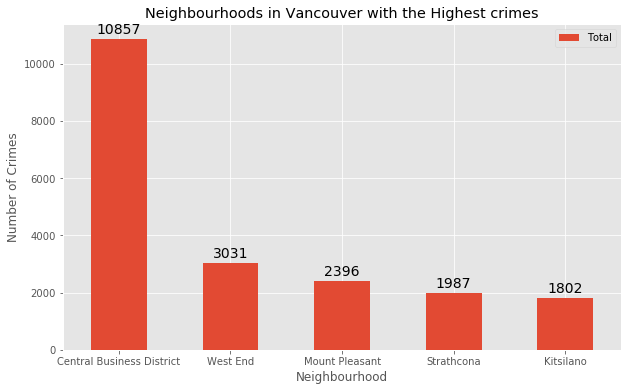

In [14]:
per_neigh = crime_neigh_top5[['Neighbourhood','Total']]

per_neigh.set_index('Neighbourhood',inplace = True)

ax = per_neigh.plot(kind='bar', figsize=(10, 6), rot=0)

ax.set_ylabel('Number of Crimes')
ax.set_xlabel('Neighbourhood')
ax.set_title('Neighbourhoods in Vancouver with the Highest crimes')

for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 14,
               )

plt.show()

Five Neighborhoods with lowest crime

In [15]:
crime_neigh_low = vnc_crime_neigh.tail(5)
crime_neigh_low

,Neighbourhood,YearBreak and Enter Commercial,YearBreak and Enter Residential/Other,YearMischief,YearOther Theft,YearTheft from Vehicle,YearTheft of Bicycle,YearTheft of Vehicle,YearVehicle Collision or Pedestrian Struck (with Fatality),YearVehicle Collision or Pedestrian Struck (with Injury),Total
23,West Point Grey,18,71,50,11,157,32,11,0,22,372
0,Arbutus Ridge,12,78,49,18,111,12,12,1,18,311
17,South Cambie,22,42,41,38,111,19,8,0,11,292
18,Stanley Park,6,2,8,0,109,14,3,0,12,154
12,Musqueam,0,4,3,0,4,2,2,0,2,17


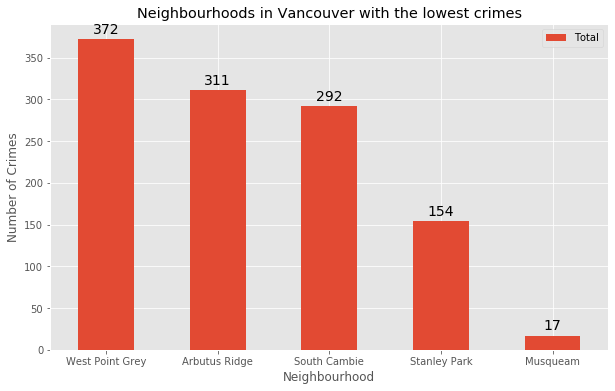

In [16]:
per_neigh = crime_neigh_low[['Neighbourhood','Total']]

per_neigh.set_index('Neighbourhood',inplace = True)

ax = per_neigh.plot(kind='bar', figsize=(10, 6), rot=0)

ax.set_ylabel('Number of Crimes')
ax.set_xlabel('Neighbourhood')
ax.set_title('Neighbourhoods in Vancouver with the lowest crimes')

for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 14,
               )

plt.show()

####Borough is Vancouver with Highest Crime

In [ ]:
vnc_crime_cat = pd.pivot_table(vnc_boroughs_crime,
                               values=['Year'],
                               index=['Borough'],
                               columns=['Type'],
                               aggfunc=len,
                               fill_value=0,
                               margins=True)
vnc_crime_cat

Year  ...       
Type            Break and Enter Commercial  ...    All
Borough                                     ...       
Central                                787  ...  14042
East Side                              786  ...  12400
South Vancouver                         49  ...   1182
West Side                              403  ...   7204
All                                   2025  ...  34828

[5 rows x 10 columns]

In [ ]:
vnc_crime_cat.reset_index(inplace = True)
vnc_crime_cat.columns = vnc_crime_cat.columns.map(''.join)
vnc_crime_cat.rename(columns={'YearAll':'Total',
                              'YearBreak and Enter Commercial' : 'Break and Enter Commercial',
                              'YearBreak and Enter Residential/Other' : 'Break and Enter Residential',
                              'YearMischief' : 'Mischief',
                              'YearOther Theft' : 'Other',
                              'YearTheft from Vehicle' : 'Theft from Vehicle',
                              'YearTheft of Bicycle' : 'Theft of Bicycle',
                              'YearTheft of Vehicle' : 'Theft of Vehicle',
                              'YearVehicle Collision or Pedestrian Struck (with Fatality)' : 'Vehicle Collision or Pedestrian Struck (with Fatality)',
                              'YearVehicle Collision or Pedestrian Struck (with Injury)' : 'Vehicle Collision or Pedestrian Struck (with Injury)'}, inplace=True)
# To ignore bottom All in Borough
vnc_crime_cat = vnc_crime_cat.head(4)
vnc_crime_cat

,Borough,Break and Enter Commercial,Break and Enter Residential,Mischief,Other,Theft from Vehicle,Theft of Bicycle,Theft of Vehicle,Vehicle Collision or Pedestrian Struck (with Fatality),Vehicle Collision or Pedestrian Struck (with Injury),Total
0,Central,787,198,2280,2489,6871,857,245,1,314,14042
1,East Side,786,1043,2192,1674,4754,678,605,8,660,12400
2,South Vancouver,49,156,187,88,483,36,71,1,111,1182
3,West Side,403,1000,1062,696,2838,588,225,3,389,7204


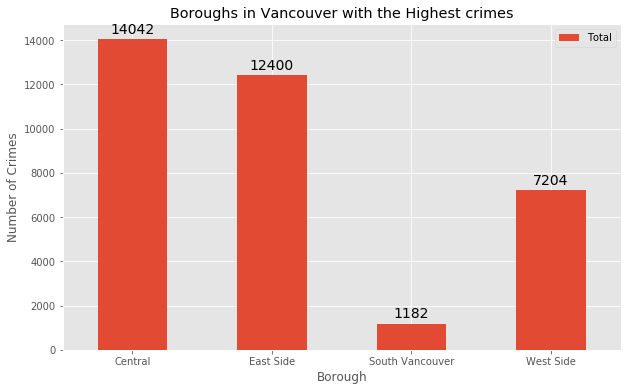

In [ ]:
per_borough = vnc_crime_cat[['Borough','Total']]

per_borough.set_index('Borough',inplace = True)

ax = per_borough.plot(kind='bar', figsize=(10, 6), rot=0)

ax.set_ylabel('Number of Crimes')
ax.set_xlabel('Borough')
ax.set_title('Boroughs in Vancouver with the Highest crimes')

for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 14,
               )

plt.show()

### Based on exploratory data analysis it is clear that South Vancouver has the lowest crimes

##### Since South Vancouver has very little number of neighborhoods and opening a commercial establishment would not be viable, we can choose the next borough with lowest crime which is **West Side**.

####Different types of crimes recorded in the West Side Borough

####West side was chosen because crime type Break and enter Commercial is also low amongst other crimes types which makes West Side ideal destination for opening of commercial establishments

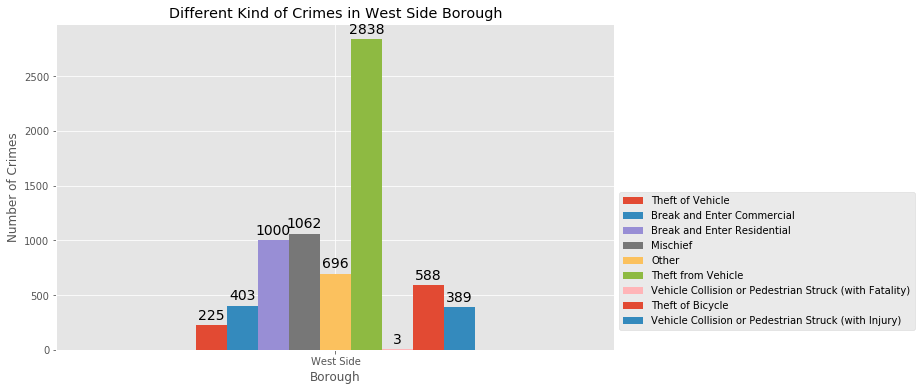

In [ ]:
 vnc_ws_df = vnc_crime_cat[vnc_crime_cat['Borough'] == 'West Side']

 vnc_ws_df = vnc_ws_df.sort_values(['Total'], ascending = True, axis = 0)

vnc_ws = vnc_ws_df[['Borough','Theft of Vehicle', 'Break and Enter Commercial','Break and Enter Residential','Mischief','Other',
                 'Theft from Vehicle','Vehicle Collision or Pedestrian Struck (with Fatality)','Theft of Bicycle',
                 'Vehicle Collision or Pedestrian Struck (with Injury)']]


vnc_ws.set_index('Borough',inplace = True)

ax = vnc_ws.plot(kind='bar', figsize=(10, 6), rot=0)

ax.set_ylabel('Number of Crimes')
ax.set_xlabel('Borough')
ax.set_title('Different Kind of Crimes in West Side Borough')

for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=3), 
                (p.get_x()+p.get_width()/3., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(5, 10), 
                textcoords='offset points',
                fontsize = 14
               )
    ax.legend(loc='upper left', bbox_to_anchor=(1.00, 0.5))

plt.show()

###**Part 3**: Creating a new consolidated dataset of the Neighborhoods, along with their boroughs, crime data and the respective Neighbourhood's co-ordinates.<a name="part3"></a>: 

####This data will be fetched using OpenCage Geocoder to find the safest borough and explore the neighbourhood by plotting it on maps using Folium and perform exploratory data analysis.

#####Restricting the rows in the data frame to only those with West side as Borough

In [ ]:
vnc_ws_neigh = vnc_boroughs_crime

#vnc_ws_neigh.drop(['Type','Year', 'Month', 'Day', 'Hour'], axis = 1, inplace = True)
vnc_ws_neigh = vnc_ws_neigh[vnc_ws_neigh['Borough'] == 'West Side']
vnc_ws_neigh.reset_index(inplace=True, drop=True)

print('Number of Neighbourhoods in West Side Borough', len(vnc_ws_neigh['Neighbourhood'].unique()))

vnc_ws_neigh['Neighbourhood'].unique()

Number of Neighbourhoods in West Side Borough 10


array(['Shaughnessy', 'Fairview', 'Oakridge', 'Marpole', 'Kitsilano',
       'Kerrisdale', 'West Point Grey', 'Arbutus Ridge', 'South Cambie',
       'Dunbar-Southlands'], dtype=object)

#####Creating a new Data frame with Lat, Lng being fetched from OpenCage geocoder

In [ ]:
Latitude = []
Longitude = []
Borough = []
Neighbourhood = vnc_ws_neigh['Neighbourhood'].unique()



key = '830323b5ca694362904814ff0a11b803'
geocoder = OpenCageGeocode(key)

for i in range(len(Neighbourhood)):
    address = '{}, Vancouver, BC, Canada'.format(Neighbourhood[i])
    location = geocoder.geocode(address)
    Latitude.append(location[0]['geometry']['lat'])
    Longitude.append(location[0]['geometry']['lng'])
    Borough.append('West Side')
print(Latitude, Longitude)

#print('The geograpical coordinate of Vancouver City are {}, {}.'.format(latitude, longitude))

[49.2518626, 49.2641128, 49.2308288, 49.2092233, 49.2694099, 49.2346728, 49.2644843, 49.2409677, 49.2466847, 49.2534601] [-123.1380226, -123.1268352, -123.1311342, -123.1361495, -123.155267, -123.1553893, -123.1854326, -123.1670008, -123.120915, -123.1850439]


####Glimpse of the new Data Frame with Neighborhoods in West Side Borough of Vancoouver along with centroid of their co-ordinates

In [ ]:
ws_neig_dict = {'Neighbourhood': Neighbourhood,'Borough':Borough,'Latitude': Latitude,'Longitude':Longitude}
ws_neig_geo = pd.DataFrame(data=ws_neig_dict, columns=['Neighbourhood', 'Borough', 'Latitude', 'Longitude'], index=None)

ws_neig_geo

,Neighbourhood,Borough,Latitude,Longitude
0,Shaughnessy,West Side,49.251863,-123.138023
1,Fairview,West Side,49.264113,-123.126835
2,Oakridge,West Side,49.230829,-123.131134
3,Marpole,West Side,49.209223,-123.136150
4,Kitsilano,West Side,49.269410,-123.155267
5,Kerrisdale,West Side,49.234673,-123.155389
6,West Point Grey,West Side,49.264484,-123.185433
7,Arbutus Ridge,West Side,49.240968,-123.167001
8,South Cambie,West Side,49.246685,-123.120915
9,Dunbar-Southlands,West Side,49.253460,-123.185044


####Fetching the Geographical co-ordiantes of Vancouver to plot on Map

In [ ]:
address = 'Vancouver, BC, Canada'

location = geocoder.geocode(address)
latitude = location[0]['geometry']['lat']
longitude = location[0]['geometry']['lng']

print('The geograpical coordinate of Vancouver, Canada are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Vancouver, Canada are 49.2608724, -123.1139529.


####Using Folium to plot Vancouver City's West Side Borough and it's Neighborhoods

In [ ]:
van_map = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, borough, neighborhood in zip(ws_neig_geo['Latitude'], ws_neig_geo['Longitude'], ws_neig_geo['Borough'], ws_neig_geo['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(van_map)  
    
van_map

###**Part 4**: Creating a new consolidated dataset of the Neighborhoods, boroughs, and the most common venues and the respective Neighbourhood along with co-ordinates.<a name="part4"></a>: 
#####This data will be fetched using Four Square API to explore the neighbourhood venues and to apply machine learning algorithm to cluster the neighbourhoods and present the findings by plotting it on maps using Folium.

####Setting Up Foursquare Credentials

In [ ]:
#Four Square Credentials

CLIENT_ID = 'XVY0YGK3DX5QGHMN2TGSK2EWA55P3JNPIVC5QVW5SGIGUI2L'
CLIENT_SECRET = 'T53Z3HT4W5DVALRIPBK2DPD4NFOCISMUTMNBLNW13KEJTAIJ'
VERSION = '20191101'
LIMIT = 100

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: XVY0YGK3DX5QGHMN2TGSK2EWA55P3JNPIVC5QVW5SGIGUI2L
CLIENT_SECRET:T53Z3HT4W5DVALRIPBK2DPD4NFOCISMUTMNBLNW13KEJTAIJ


####Defining a function to fetch top 10 venues around a given neighborhood

In [ ]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Category']
    
    return(nearby_venues)

####Generating Venues

In [ ]:
vnc_ws_venues = getNearbyVenues(names=ws_neig_geo['Neighbourhood'],
                                   latitudes=ws_neig_geo['Latitude'],
                                   longitudes=ws_neig_geo['Longitude']
                                  )

Shaughnessy
Fairview
Oakridge
Marpole
Kitsilano
Kerrisdale
West Point Grey
Arbutus Ridge
South Cambie
Dunbar-Southlands


####Data frame containing venues for each neighborhood in West Side

In [ ]:
print(vnc_ws_venues.shape)
vnc_ws_venues.head()

(229, 5)


,Neighbourhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Category
0,Shaughnessy,49.251863,-123.138023,Bus Stop 50209 (10),Bus Stop
1,Shaughnessy,49.251863,-123.138023,Angus Park,Park
2,Shaughnessy,49.251863,-123.138023,Crepe & Cafe,French Restaurant
3,Fairview,49.264113,-123.126835,Gyu-Kaku Japanese BBQ,BBQ Joint
4,Fairview,49.264113,-123.126835,CRESCENT nail and spa,Nail Salon


####Venue Count per neighborhood

In [ ]:
vnc_ws_venues.groupby('Neighbourhood').count().drop(['Neighborhood Latitude','Neighborhood Longitude','Venue Category'], axis = 1)

,Venue
Neighbourhood,
Arbutus Ridge,5
Dunbar-Southlands,8
Fairview,25
Kerrisdale,40
Kitsilano,47
Marpole,30
Oakridge,8
Shaughnessy,3
South Cambie,18


In [ ]:
print('There are {} uniques categories.'.format(len(vnc_ws_venues['Venue Category'].unique())))

There are 86 uniques categories.


###Modelling<a name="mdl"></a>

#####One Hot Encoding to Analyze Each Neighborhood

In [ ]:
# one hot encoding
vnc_onehot = pd.get_dummies(vnc_ws_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
vnc_onehot['Neighbourhood'] = vnc_ws_venues['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [vnc_onehot.columns[-1]] + list(vnc_onehot.columns[:-1])
vnc_onehot = vnc_onehot[fixed_columns]

vnc_onehot.head()

,Neighbourhood,American Restaurant,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Bakery,Bank,Bar,Beach,Bookstore,Boutique,Breakfast Spot,Bubble Tea Shop,Bus Station,Bus Stop,Café,Camera Store,Cantonese Restaurant,Chinese Restaurant,Coffee Shop,Convenience Store,Deli / Bodega,Dessert Shop,Dim Sum Restaurant,Diner,Falafel Restaurant,Fast Food Restaurant,Food,Food Truck,French Restaurant,Gastropub,Greek Restaurant,Grocery Store,Gym Pool,Hobby Shop,Ice Cream Shop,Indian Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,...,Malay Restaurant,Massage Studio,Mediterranean Restaurant,Mexican Restaurant,Music Store,Nail Salon,Nightlife Spot,Noodle House,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plaza,Pool,Portuguese Restaurant,Pub,Rest Area,Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Seafood Restaurant,Shanghai Restaurant,Shop & Service,South American Restaurant,Spa,Sporting Goods Shop,Sushi Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Tea Room,Tennis Court,Thai Restaurant,Thrift / Vintage Store,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Shop,Women's Store,Yoga Studio
0,Shaughnessy,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Shaughnessy,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Shaughnessy,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Fairview,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Fairview,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
vnc_onehot.shape

(229, 87)

In [ ]:
vnc_ws_grouped = vnc_onehot.groupby('Neighbourhood').mean().reset_index()
vnc_ws_grouped

,Neighbourhood,American Restaurant,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Bakery,Bank,Bar,Beach,Bookstore,Boutique,Breakfast Spot,Bubble Tea Shop,Bus Station,Bus Stop,Café,Camera Store,Cantonese Restaurant,Chinese Restaurant,Coffee Shop,Convenience Store,Deli / Bodega,Dessert Shop,Dim Sum Restaurant,Diner,Falafel Restaurant,Fast Food Restaurant,Food,Food Truck,French Restaurant,Gastropub,Greek Restaurant,Grocery Store,Gym Pool,Hobby Shop,Ice Cream Shop,Indian Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,...,Malay Restaurant,Massage Studio,Mediterranean Restaurant,Mexican Restaurant,Music Store,Nail Salon,Nightlife Spot,Noodle House,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plaza,Pool,Portuguese Restaurant,Pub,Rest Area,Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Seafood Restaurant,Shanghai Restaurant,Shop & Service,South American Restaurant,Spa,Sporting Goods Shop,Sushi Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Tea Room,Tennis Court,Thai Restaurant,Thrift / Vintage Store,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Shop,Women's Store,Yoga Studio
0,Arbutus Ridge,0.000000,0.000000,0.000000,0.00,0.200000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000,0.000,0.000000,0.000000,0.000,0.000000,0.000000,...,0.000000,0.000000,0.000,0.000000,0.000000,0.00,0.2,0.000000,0.000000,0.000000,0.200,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Dunbar-Southlands,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000,0.125000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.125000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000,0.000000,0.125000,0.000,0.125000,0.125000,...,0.000000,0.000000,0.000,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.125,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.125000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,Fairview,0.000000,0.000000,0.080000,0.04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.040,0.000000,0.040,0.160000,0.000000,0.000000,0.000000,0.000000,0.04,0.040000,0.040000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000,0.000000,0.040000,0.000,0.000000,0.040000,...,0.040000,0.000000,0.000,0.000000,0.000000,0.04,0.0,0.000000,0.080000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.040000,0.000000,0.040,0.040000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.040000,0.04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.040000,0.000000,0.000000,0.000000
3,Kerrisdale,0.000000,0.000000,0.025000,0.00,0.025000,0.025000,0.000000,0.000000,0.000000,0.025,0.025000,0.025000,0.000000,0.000000,0.025000,0.025,0.000000,0.075,0.125000,0.025000,0.000000,0.025000,0.000000,0.00,0.000000,0.025000,0.000,0.000000,0.000000,0.000000,0.000000,0.025000,0.025,0.025,0.000000,0.000000,0.000,0.025000,0.025000,...,0.000000,0.000000,0.025,0.000000,0.000000,0.00,0.0,0.025000,0.000000,0.000000,0.025,0.050000,0.025000,0.000000,0.000000,0.025,0.000000,0.000000,0.000000,0.000000,0.000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.050000,0.00,0.000000,0.050000,0.000000,0.025000,0.000000,0.000000,0.025000,0.000000,0.000000,0.000000
4,Kitsilano,0.042553,0.000000,0.021277,0.00,0.063830,0.000000,0.021277,0.021277,0.000000,0.000,0.021277,0.000000,0.021277,0.000000,0.000000,0.000,0.000

In [ ]:
vnc_ws_grouped.shape

(10, 87)

####Top 5 most common venues across neighborhoods

In [ ]:
num_top_venues = 5

for hood in vnc_ws_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = vnc_ws_grouped[vnc_ws_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Arbutus Ridge----
            venue  freq
0       Pet Store   0.2
1          Bakery   0.2
2  Nightlife Spot   0.2
3             Spa   0.2
4   Grocery Store   0.2


----Dunbar-Southlands----
                 venue  freq
0         Liquor Store  0.12
1  Japanese Restaurant  0.12
2   Salon / Barbershop  0.12
3          Coffee Shop  0.12
4    Indian Restaurant  0.12


----Fairview----
                 venue  freq
0          Coffee Shop  0.16
1     Asian Restaurant  0.08
2                 Park  0.08
3   Falafel Restaurant  0.04
4  Szechuan Restaurant  0.04


----Kerrisdale----
                venue  freq
0         Coffee Shop  0.12
1  Chinese Restaurant  0.08
2      Sandwich Place  0.05
3    Sushi Restaurant  0.05
4            Tea Room  0.05


----Kitsilano----
                 venue  freq
0     Sushi Restaurant  0.06
1               Bakery  0.06
2          Coffee Shop  0.06
3  American Restaurant  0.04
4       Ice Cream Shop  0.04


----Marpole----
                 venue  freq
0     Sus

####Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [ ]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [ ]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighbourhood'] = vnc_ws_grouped['Neighbourhood']

for ind in np.arange(vnc_ws_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(vnc_ws_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Arbutus Ridge,Spa,Bakery,Pet Store,Grocery Store,Nightlife Spot,Yoga Studio,Diner,Falafel Restaurant,Fast Food Restaurant,Food
1,Dunbar-Southlands,Sushi Restaurant,Liquor Store,Japanese Restaurant,Italian Restaurant,Coffee Shop,Indian Restaurant,Salon / Barbershop,Fast Food Restaurant,French Restaurant,Diner
2,Fairview,Coffee Shop,Asian Restaurant,Park,Chinese Restaurant,Sandwich Place,Indian Restaurant,Korean Restaurant,Malay Restaurant,Nail Salon,Fast Food Restaurant
3,Kerrisdale,Coffee Shop,Chinese Restaurant,Pharmacy,Tea Room,Sushi Restaurant,Sandwich Place,Fast Food Restaurant,Noodle House,Dessert Shop,Pet Store
4,Kitsilano,Bakery,Coffee Shop,Sushi Restaurant,American Restaurant,Thai Restaurant,Japanese Restaurant,Tea Room,Food Truck,French Restaurant,Ice Cream Shop


### Cluster Neighbourhoods

In [ ]:
# set number of clusters
kclusters = 5

vnc_grouped_clustering = vnc_ws_grouped.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(vnc_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 4, 0, 0, 0, 0, 3, 2, 0, 0], dtype=int32)

In [ ]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

vancouver_merged = ws_neig_geo

# merge toronto_grouped with Vancouver data to add latitude/longitude for each neighborhood
vancouver_merged = vancouver_merged.join(neighborhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

vancouver_merged.head()

,Neighbourhood,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Shaughnessy,West Side,49.251863,-123.138023,2,French Restaurant,Bus Stop,Park,Yoga Studio,Dessert Shop,Diner,Falafel Restaurant,Fast Food Restaurant,Food,Food Truck
1,Fairview,West Side,49.264113,-123.126835,0,Coffee Shop,Asian Restaurant,Park,Chinese Restaurant,Sandwich Place,Indian Restaurant,Korean Restaurant,Malay Restaurant,Nail Salon,Fast Food Restaurant
2,Oakridge,West Side,49.230829,-123.131134,3,Convenience Store,Vietnamese Restaurant,Israeli Restaurant,Fast Food Restaurant,Sandwich Place,Food,Park,Sushi Restaurant,French Restaurant,Dim Sum Restaurant
3,Marpole,West Side,49.209223,-123.136150,0,Pizza Place,Chinese Restaurant,Sushi Restaurant,Japanese Restaurant,Lingerie Store,Noodle House,Dim Sum Restaurant,Falafel Restaurant,Plaza,Café
4,Kitsilano,West Side,49.269410,-123.155267,0,Bakery,Coffee Shop,Sushi Restaurant,American Restaurant,Thai Restaurant,Japanese Restaurant,Tea Room,Food Truck,French Restaurant,Ice Cream Shop


In [ ]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(vancouver_merged['Latitude'], vancouver_merged['Longitude'], vancouver_merged['Neighbourhood'], vancouver_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

###Analysis<a name="analysis"></a>

####Examining the resulting Clusters

####Cluster 1

In [ ]:
vancouver_merged.loc[vancouver_merged['Cluster Labels'] == 0, vancouver_merged.columns[[1] + list(range(5, vancouver_merged.shape[1]))]]

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,West Side,Coffee Shop,Asian Restaurant,Park,Chinese Restaurant,Sandwich Place,Indian Restaurant,Korean Restaurant,Malay Restaurant,Nail Salon,Fast Food Restaurant
3,West Side,Pizza Place,Chinese Restaurant,Sushi Restaurant,Japanese Restaurant,Lingerie Store,Noodle House,Dim Sum Restaurant,Falafel Restaurant,Plaza,Café
4,West Side,Bakery,Coffee Shop,Sushi Restaurant,American Restaurant,Thai Restaurant,Japanese Restaurant,Tea Room,Food Truck,French Restaurant,Ice Cream Shop
5,West Side,Coffee Shop,Chinese Restaurant,Pharmacy,Tea Room,Sushi Restaurant,Sandwich Place,Fast Food Restaurant,Noodle House,Dessert Shop,Pet Store
6,West Side,Japanese Restaurant,Coffee Shop,Café,Vegetarian / Vegan Restaurant,Bakery,Pub,Sushi Restaurant,Dessert Shop,Pizza Place,Pharmacy
8,West Side,Coffee Shop,Bus Stop,Malay Restaurant,Juice Bar,Cantonese Restaurant,Grocery Store,Sushi Restaurant,Park,Café,Bank


####Cluster 2

In [ ]:
vancouver_merged.loc[vancouver_merged['Cluster Labels'] == 1, vancouver_merged.columns[[1] + list(range(5, vancouver_merged.shape[1]))]]

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,West Side,Spa,Bakery,Pet Store,Grocery Store,Nightlife Spot,Yoga Studio,Diner,Falafel Restaurant,Fast Food Restaurant,Food


####Cluster 3

In [ ]:
vancouver_merged.loc[vancouver_merged['Cluster Labels'] == 2, vancouver_merged.columns[[1] + list(range(5, vancouver_merged.shape[1]))]]

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,West Side,French Restaurant,Bus Stop,Park,Yoga Studio,Dessert Shop,Diner,Falafel Restaurant,Fast Food Restaurant,Food,Food Truck


####Cluster 4

In [ ]:
vancouver_merged.loc[vancouver_merged['Cluster Labels'] == 3, vancouver_merged.columns[[1] + list(range(5, vancouver_merged.shape[1]))]]

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,West Side,Convenience Store,Vietnamese Restaurant,Israeli Restaurant,Fast Food Restaurant,Sandwich Place,Food,Park,Sushi Restaurant,French Restaurant,Dim Sum Restaurant


####Cluster 5

In [ ]:
vancouver_merged.loc[vancouver_merged['Cluster Labels'] == 4, vancouver_merged.columns[[1] + list(range(5, vancouver_merged.shape[1]))]]

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,West Side,Sushi Restaurant,Liquor Store,Japanese Restaurant,Italian Restaurant,Coffee Shop,Indian Restaurant,Salon / Barbershop,Fast Food Restaurant,French Restaurant,Diner


## Results and Discussion <a name="results"></a>

The objective of the business problem was to help stakeholders identify one of the safest borough in Vancouver, and an appropriate neighborhood within the borough to set up a commercial establishment especially a Grocery store. This has been achieved by first making use of Vancouver crime data to identify a safe borugh with considerable number of neighborhood for any business to be viable. After selecting the borough it was imperative to choose the right neighborhood where grocery shops were not among venues in a close proximity to each other. We achieved this by grouping the neighborhoods into clusters to assist the stakeholders by providing them with relavent data about venues and safety of a given neighborhood.

## Conclusion <a name="conclusion"></a>

We have explored the crime data to understand different types of crimes in all neighborhoods of Vancouver and later categorized them into different boroughs, this helped us group the neighborhoods into boroughs and choose the safest borough first. Once we confirmed the borough the number of neighborhoods for consideration also comes down, we further shortlist the neighborhoods based on the common venues, to choose a neighborhood which best suits the business problem.